<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Описание данных**


Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак:
- Exited — факт ухода клиента

**Цель исследования**

Построить модель с максимально большим значением F1-меры, доведя метрику по крайней мере до 0.59. 

**Ход исследования**

Данные о тарифах получены их файла `datasets/Churn.csv`. В проекте мы изучим данные, разделим файлы на выборки, исследуем разлчные модели для поиска наилучшей метрики F1, в том числе с учетом возможного дисбаланса, проверим качество на тестовой выборке, а также проведем исследование модели метрикой AUC-ROC.

Таким образом, исследование пройдет в ряд этапов:
- открытие файла и изучение данных; 
- разделение исходных данных на обучающую, валидационную и тестовую выборки;
- исследование баланса, качества разных моделей;
- применение различных методов устранения дисбаланса;
- выбор модели с наибольшей *F1-метрикой*;
- проверка качества наилучшей модели на тестовой выборке;
- исследование модели метрикой AUC-ROC;
- формулировка выводов.

## Подготовка данных

Предварительно импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tqdm import tqdm
 n

Загрузим файл с базой данных, посмотрим на основные характеристики датафрейма.

In [2]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
except:
    df = pd.read_csv('D:/learn_data/Churn.csv')

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Также сразу же проверим данные на наличие дубликатов. 

In [5]:
df.duplicated().sum()

0

Как мы видим, явных дубликатов не имеется. С учетом тоого, что в колонке `'Tenure'` имеются попуски, взглянем на то, какие значения имеются в данной колонке. 

In [6]:
df['Tenure'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan])

От пропусков надо избавиться (поскольку моделям придется работать с числами), что можно сделать различными способами, например, заменой пропусков или их удалением. С учетом того, что в столбце `'Tenure'` содержатся сведения о количестве лет, в течение которых лицо являлось клиентом банка, при этом имется все значения от **0** до **10**, а также того, что нам не известен механизм образования пропусков, сделать адекватную замену данных попусков будет сложно. В то же время, удаление данных пропусков, может теоретически исказить общую картину, поэтому предлагаю заменить пропуски значением **-1**, поставив таким образом заглушку, а в дальнейшем предоставим нашим моделям обучаться, используя данные, содержащиеся в строках с такими попусками, при этом не допусив необоснованного роста количества какого-либо из адекватных зачений данного столбца.    

In [7]:
df['Tenure'].median()

5.0

In [8]:
df['Tenure'] = df['Tenure'].fillna(round(df['Tenure'].mean()))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Итак, пропусков во фрейме данных больше не имеется. Теперь, учитывая тот факт, что данные, содержащиеся в  столбцах `'RowNumber', 'CustomerId', 'Surname'` не содержат каких-либо сведений, которые могут повлиять на значение целевго признака (уход клиента из банка, который никак не может зависить от порядкового номера строки датафрейма, уникального идентификатора клиента или его фамилии), данные этих столбцов нам не понадобяться, поэтому просто удалим их.

In [9]:
data = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


С учетом того, что столбцы `'Geography', 'Gender'` во фрейме данных заполенены нечисловыми значениями, приведем их в понимаемый моделями вид путем прямого кодирования с помощью *get_dummies()*. 

In [11]:
data_ohe = pd.get_dummies(data, drop_first=True)

Давайте взглянем также на то, имеется ли между столбцами нашей базы данных корреляция и на ее степень.

In [12]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr = data_ohe.corr()
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Корреляция данных")\
    .set_precision(2)\
    .set_table_styles(magnify())

C:\Users\user\AppData\Local\Temp\ipykernel_20424\1736291848.py:15: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap, axis=1)\


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CreditScore,1.00,-0.00,-0.00,0.01,0.01,-0.01,0.03,-0.00,-0.03,0.01,0.00,-0.00
Age,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29,0.05,-0.00,-0.03
Tenure,-0.00,-0.01,1.00,-0.01,0.01,0.03,-0.03,0.01,-0.02,-0.00,0.00,0.01
Balance,0.01,0.03,-0.01,1.00,-0.30,-0.01,-0.01,0.01,0.12,0.40,-0.13,0.01
NumOfProducts,0.01,-0.03,0.01,-0.30,1.00,0.00,0.01,0.01,-0.05,-0.01,0.01,-0.02
HasCrCard,-0.01,-0.01,0.03,-0.01,0.00,1.00,-0.01,-0.01,-0.01,0.01,-0.01,0.01
IsActiveMember,0.03,0.09,-0.03,-0.01,0.01,-0.01,1.00,-0.01,-0.16,-0.02,0.02,0.02
EstimatedSalary,-0.00,-0.01,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01,0.01,-0.01,-0.01
Exited,-0.03,0.29,-0.02,0.12,-0.05,-0.01,-0.16,0.01,1.00,0.17,-0.05,-0.11
Geography_Germany,0.01,0.05,-0.00,0.40,-0.01,0.01,-0.02,0.01,0.17,1.00,-0.33,-0.02


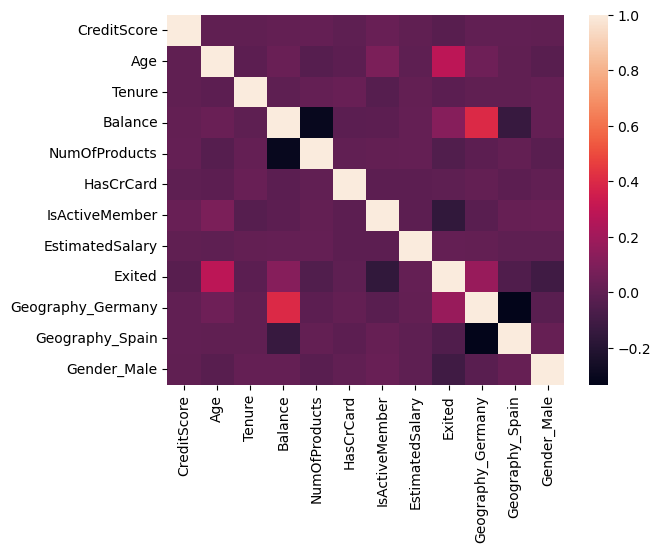

In [13]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns);

Как мы видим, у целевого признака нашего датафрейма имеется некоторая корреляция со столбцами `'Age', 'Gender', 'Balance', 'IsActiveMember'`, но она не такая большая. Далее разделим базу данных на две таблицы: с признаками и целевым признаком.

In [14]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

Также разделим наши таблицы на обучающу, валидационную и тестовую выборки, используя стратификацию. При этом в целях возможности адекватной поверки проекта, закрепим псевдослучайность для наших алгоритмов, выбрав параметр `random_state` как *3301*.

In [15]:
features_tmp, features_test, target_tmp, target_test = train_test_split(features, target, test_size=0.20, random_state=3301)
features_train, features_valid, target_train, target_valid = train_test_split(features_tmp, target_tmp, test_size=0.25, 
                                                                              random_state=3301)

In [16]:
print('Обучащая выборка: количество целевого признака "1":', target_train[target_train==1].sum(), 
      '; среднее целевого признака:', target_train.mean())
print('Валидационная выборка: количество целевого признака "1":', target_valid[target_valid==1].sum(), 
      '; среднее целевого признака:', target_valid.mean())
print('Тествая выборка: количество целевого признака "1":', target_test[target_test==1].sum(), 
      '; среднее целевого признака:', target_test.mean())

Обучащая выборка: количество целевого признака "1": 1200 ; среднее целевого признака: 0.2
Валидационная выборка: количество целевого признака "1": 444 ; среднее целевого признака: 0.222
Тествая выборка: количество целевого признака "1": 393 ; среднее целевого признака: 0.1965


Кроме того, у нас имеется ряд значений в разичных стобцах, которые существенно отличаются по своим значениям, что может негативно отразиться на обучении модели в связи с чем проведем масштабирование признаков, используя структуру для стандартизации данных *StandardScaler*, настроив ее на обучающей выборке и затем преобразовав данные признаков. 

In [17]:
num = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[num])
features_train[num] = scaler.transform(features_train[num])
features_valid[num] = scaler.transform(features_valid[num])
features_test[num] = scaler.transform(features_test[num])

**Вывод:** Как мы видим, у нас имеется база данных, содержащая сведения о 10000 случаях, в которых имееются сведения о клиентах банка, их кредитном рейтинге, стране проживания, поле, возрасте, времени сотрудничества с банком, балансе, колчестве используемых продуктов банка, наличии кредитной карты, актвивности клиента и его предполагаемой заработной плате (признаки) и данные об уходе (либо нет) клиента из банка (целевой признак). В тоже время следует заметить, что данные неравномерны, а разделены в соотношении примерно 1 к 4, поскольку уход из банка имел место у примерно 20% клиентов.

## Исследование задачи

Теперь давайте взглянем, каким образом будут обучатся наши модели на имеющихся данных. В качестве моделей используем логистическую регрессию, а также различные варианты дерева решений (предлагаю взять варианты с глубиной от **1** до **15**) и случайного леса (в данном случае добавим варианты количества деревьев от 2 до 50, которые будем исследовать с шагом в 3). При этом пока не будем учитывать несбалансированность данных. В качестве метрики оценки моделей используем F1-метрику.

In [18]:
model_logistic = LogisticRegression(random_state=3301, solver='liblinear', max_iter=100)

model_logistic.fit(features_train, target_train) 
logistic_pred = model_logistic.predict(features_valid)
result_logistic = f1_score(target_valid, logistic_pred) 

print("F1 модели логической регрессии на валидационной выборке:", result_logistic)

F1 модели логической регрессии на валидационной выборке: 0.2753872633390706


Как видно, результат **0,27** является крайне посредственным. Посмотрим, как будет справляться дерево решений.

100%|██████████| 15/15 [00:00<00:00, 46.71it/s]

F1 наилучшей модели на валидационной выборке: 0.5682137834036567 Глубина дерева: 8


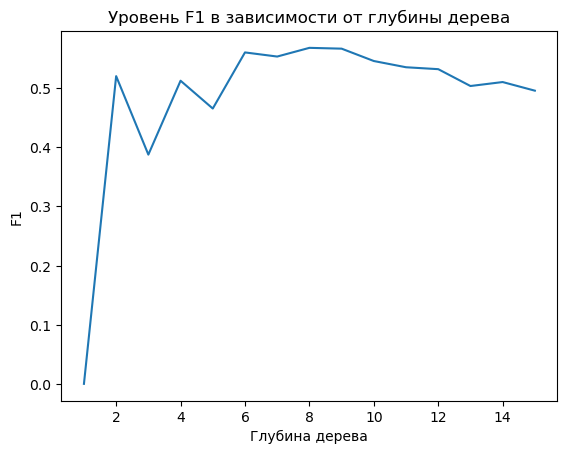

In [19]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
linegraf = []
indexgraf = []

for depth in tqdm(range(1, 16)):
    model_tree = DecisionTreeClassifier(random_state=3301, max_depth=depth)
    
    model_tree.fit(features_train, target_train) 
    tree_pred = model_tree.predict(features_valid) 
    
    result = f1_score(target_valid, tree_pred) 
    
    if result > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result
        best_depth_tree = depth
    linegraf.append(result) 
    indexgraf.append(depth)

line = pd.Series(linegraf, index=indexgraf)

print("F1 наилучшей модели на валидационной выборке:", best_result_tree, "Глубина дерева:", best_depth_tree)
line.plot(title='Уровень F1 в зависимости от глубины дерева', xlabel='Глубина дерева', ylabel='F1');

Дерево решений показало уже более лучший результат с F1-метрикой около **0,57** при глубине дерева **8**. Теперь посмотрим как будут обучаться модели случайного леса.

In [20]:
best_model_forest = None
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0

for est in tqdm(range(2, 51, 3)):
    for depth in range (1, 16):
        model_forest = RandomForestClassifier(random_state=3301, criterion='gini', n_estimators=est, max_depth=depth)
        
        model_forest.fit(features_train, target_train) 
        forest_pred = model_forest.predict(features_valid) 
    
        result = f1_score(target_valid, forest_pred)
        
        if result > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result
            best_est_forest = est
            best_depth_forest = depth
        
print("F1 наилучшей модели на валидационной выборке:", best_result_forest, "Количество деревьев:", 
      best_est_forest, "Максимальная глубина:", best_depth_forest)

100%|██████████| 17/17 [00:33<00:00,  1.99s/it]

F1 наилучшей модели на валидационной выборке: 0.5818181818181818 Количество деревьев: 35 Максимальная глубина: 15


Как видим, модель случайнго леса с количеством деревьев **35** и глубиной **15** показала наилучший результат с F1-метрикой около **0,58**.

**Вывод:** Наилучшим образом, проявила себя модель случайнго леса с количеством деревьев **35** и глубиной **15**, которая дала наилучший результат с F1-метрикой около **0,58**. В то же время, полагаем, что калибровка моделей с учетом несбалансированности целевого признака позволит улучшить этот показатель. Возможно данной модели и могло бы хватить для достижения цели, но проверка на тестовой выборке может дать и несколько худшие результаты. 

## Борьба с дисбалансом

С учетом наличия дисбаланса в целевом признаке, предлагаю адаптировать к этому модели при обучении, используя взвешивания класса, а также путем увеличения и уменьшения выборки. Начнем с придания количественно меньшему признаку большего веса путем использования аргумента *'balanced'* в параметре *class_weight*.  

In [21]:
model = LogisticRegression(random_state=3301, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1-метрика на валидационной выборке:", f1_score(target_valid, predicted_valid))

F1-метрика на валидационной выборке: 0.5172124265323258


Как мы видим, F1-метрика модели логистической регрессии значительно улучшилась, но всё же не сответствует поставленной цели.

F1 наилучшей модели на валидационной выборке: 0.587819947043248 Глубина дерева: 5


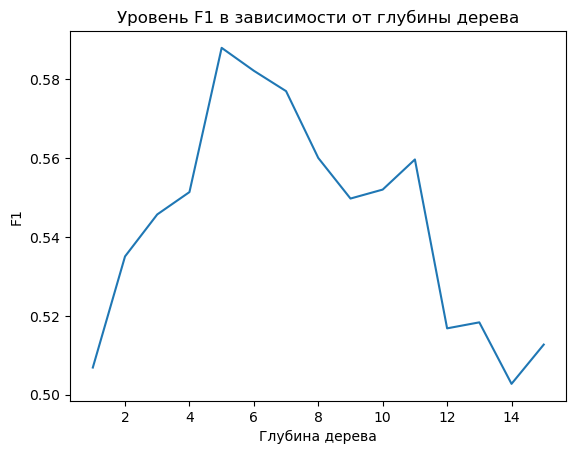

In [22]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
best_result_train = 0
linegraf = []
indexgraf = []

for depth in range(1, 16):
    model_tree = DecisionTreeClassifier(random_state=3301, max_depth=depth, class_weight='balanced')
    
    model_tree.fit(features_train, target_train) 
    tree_pred = model_tree.predict(features_valid) 
    
    result = f1_score(target_valid, tree_pred) 
    
    if result > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result
        best_depth_tree = depth
    linegraf.append(result) 
    indexgraf.append(depth)

line = pd.Series(linegraf, index=indexgraf)

print('F1 наилучшей модели на валидационной выборке:', best_result_tree, 'Глубина дерева:', best_depth_tree)
line.plot(title='Уровень F1 в зависимости от глубины дерева', xlabel='Глубина дерева', ylabel='F1');

Такой вариант на модели решающего дерева практически не отразился на F1-метрике, однако, глубина уменьшилась.

In [23]:
best_model_forest = None
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0

for est in tqdm(range(2, 51, 3)):
    for depth in range (1, 16):
        model_forest = RandomForestClassifier(random_state=3301, criterion='gini', n_estimators=est, max_depth=depth, class_weight='balanced')
        
        model_forest.fit(features_train, target_train) 
        forest_pred = model_forest.predict(features_valid) 
    
        result = f1_score(target_valid, forest_pred)
        
        if result > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result

            best_est_forest = est
            best_depth_forest = depth
        

print("F1 наилучшей модели на валидационной выборке:", best_result_forest,
      "Количество деревьев:", best_est_forest, "Максимальная глубина:", best_depth_forest)

100%|██████████| 17/17 [00:33<00:00,  1.96s/it]

F1 наилучшей модели на валидационной выборке: 0.642051282051282 Количество деревьев: 47 Максимальная глубина: 8


Как видим, модель случайного леса с количеством деревьев **47** и глубиной **8**, показала еще более лучший результат, увеличив F1-метрику до чуть более **0,64**.

Далее попробуем решить проблему дисбаланса классов с помощью увеличения выборки техникой *upsampling*.

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=3301)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [25]:
model = LogisticRegression(random_state=3301, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1 на валидационной выборке:", f1_score(target_valid, predicted_valid))

F1 на валидационной выборке: 0.5172124265323258


Как видим, на значениях F1-метрики логистической регрессии этот вариант практически не сказался.

F1 наилучшей модели на валидационной выборке: 0.587819947043248 Глубина дерева: 5


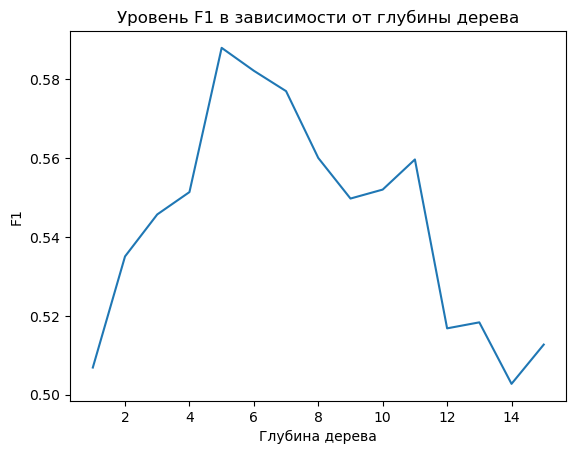

In [26]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
linegraf = []
indexgraf = []

for depth in range(1, 16):
    model_tree = DecisionTreeClassifier(random_state=3301, max_depth=depth)
    
    model_tree.fit(features_upsampled, target_upsampled) 
    tree_pred = model_tree.predict(features_valid) 
    
    result = f1_score(target_valid, tree_pred) 
    
    if result > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result
        best_depth_tree = depth
    linegraf.append(result) 
    indexgraf.append(depth)

line = pd.Series(linegraf, index=indexgraf)

print('F1 наилучшей модели на валидационной выборке:', best_result_tree, 'Глубина дерева:', best_depth_tree)
line.plot(title='Уровень F1 в зависимости от глубины дерева', xlabel='Глубина дерева', ylabel='F1');

Данный вариант также практически не изменил F1-метрику модели решающего дерева.

In [27]:
best_model_forest = None
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0

for est in tqdm(range(2, 51, 3)):
    for depth in range (1, 16):
        model_forest = RandomForestClassifier(random_state=3301, criterion='gini', n_estimators=est, max_depth=depth)
        
        model_forest.fit(features_upsampled, target_upsampled) 
        forest_pred = model_forest.predict(features_valid) 
    
        result = f1_score(target_valid, forest_pred)
        
        if result > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result

            best_est_forest = est
            best_depth_forest = depth
        
print('F1 наилучшей модели на валидационной выборке:', best_result_forest, 
      'Количество деревьев:', best_est_forest, 'Mаксимальная глубина:', best_depth_forest)

100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

F1 наилучшей модели на валидационной выборке: 0.648587570621469 Количество деревьев: 41 Mаксимальная глубина: 12


При этом методе модель случайного леса с количеством деревьев **41** и глубиной **12** повысило F1-метрику на валидационной выборке чуть менее **0,65**. 

Далее попробуем вариант решения несбалансированности классов методом *downsampling*.

In [28]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=3301)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=3301)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=3301)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [29]:
model = LogisticRegression(random_state=3301, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1-метрика на валидационной выборке:", f1_score(target_valid, predicted_valid))

F1-метрика на валидационной выборке: 0.5210084033613446


Показатель F1-метрики логистической регрессии при данном методе лишь незначительно улучшился.

F1 наилучшей модели на валидационной выборке: 0.592328278322926 Глубина дерева: 6


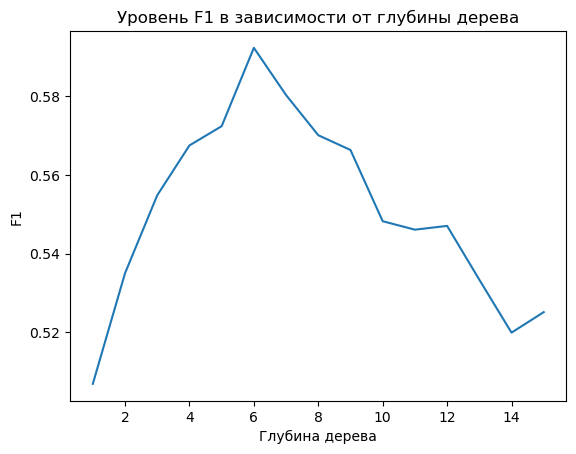

In [30]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
linegraf = []
indexgraf = []

for depth in range(1, 16):
    model_tree = DecisionTreeClassifier(random_state=3301, max_depth=depth)
    
    model_tree.fit(features_downsampled, target_downsampled) 
    tree_pred = model_tree.predict(features_valid) 
    
    result = f1_score(target_valid, tree_pred) 
    
    if result > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result
        best_depth_tree = depth
    linegraf.append(result) 
    indexgraf.append(depth)

line = pd.Series(linegraf, index=indexgraf)

print('F1 наилучшей модели на валидационной выборке:', best_result_tree, 'Глубина дерева:', best_depth_tree)
line.plot(title='Уровень F1 в зависимости от глубины дерева', xlabel='Глубина дерева', ylabel='F1');

При этом варианте лучшая модель решающего дерева едва дотягивает до неободимого нам уровня.

In [31]:
best_model_forest = None
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0

for est in tqdm(range(2, 51, 3)):
    for depth in range (1, 16):
        model_forest = RandomForestClassifier(random_state=3301, criterion='gini', n_estimators=est, max_depth=depth)
        
        model_forest.fit(features_downsampled, target_downsampled) 
        forest_pred = model_forest.predict(features_valid) 
    
        result = f1_score(target_valid, forest_pred)
        
        if result > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result

            best_est_forest = est
            best_depth_forest = depth

print('F1 наилучшей модели на валидационной выборке:', best_result_forest, 
      'Количество деревьев:', best_est_forest, 'Максимальная глубина:', best_depth_forest)

100%|██████████| 17/17 [00:19<00:00,  1.16s/it]

F1 наилучшей модели на валидационной выборке: 0.6275924256086564 Количество деревьев: 50 Максимальная глубина: 9


Лучшая модель случайного леса в данном варианте хоть и дала F1-метрике результат чуть менее **0,63**, но у нас были и более лучшие модели.  

**Вывод:** Использовав несолько вариантов борьбы с несбалансированностью целевого признака, мы выяснили, что наилучшую F1-метрику чуть менее **0,65** показала случайного леса с количеством деревьев **41** и глубиной **12** при использовании метода *upsampling*. Данную модель и будем далее проверять на тестовоый выборке.  

## Тестирование модели

Итак, проведем тестирование модели с налучшей F1-метрикой, полученной на валидационной выборке.

In [32]:
model_forest = RandomForestClassifier(random_state=3301, criterion='gini', n_estimators=41, max_depth=12)

model_forest.fit(features_upsampled, target_upsampled) 
forest_pred = model_forest.predict(features_test) 

f1_score(target_test, forest_pred)

0.6216867469879517

Успешно, как мы видим, выбранная модель достигла F1-метрики **0,62** на тестовой выборке, хотя на валидационной выборке у нее были и еще более лучшие результаты.

Теперь давайте посмотрим, какова площадь ROC-коривой нашей модели.

In [33]:
probabilities_test = model_forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(auc_roc)

0.8572229321147462


In [34]:
for threshold in np.arange(0, 0.51, 0.02):
    predicted_test = probabilities_one_test > threshold
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)
    f1 = f1_score(target_test, predicted_test)

    print(f'Порог = {threshold:.2f} | Точность = {precision:.3f}, Полнота = {recall:.3f}, F1 = {f1:.3f}')

Порог = 0.00 | Точность = 0.197, Полнота = 1.000, F1 = 0.328
Порог = 0.02 | Точность = 0.204, Полнота = 0.982, F1 = 0.338
Порог = 0.04 | Точность = 0.217, Полнота = 0.982, F1 = 0.356
Порог = 0.06 | Точность = 0.230, Полнота = 0.980, F1 = 0.373
Порог = 0.08 | Точность = 0.244, Полнота = 0.977, F1 = 0.390
Порог = 0.10 | Точность = 0.254, Полнота = 0.964, F1 = 0.402
Порог = 0.12 | Точность = 0.265, Полнота = 0.949, F1 = 0.414
Порог = 0.14 | Точность = 0.276, Полнота = 0.936, F1 = 0.426
Порог = 0.16 | Точность = 0.288, Полнота = 0.924, F1 = 0.439
Порог = 0.18 | Точность = 0.299, Полнота = 0.911, F1 = 0.451
Порог = 0.20 | Точность = 0.318, Полнота = 0.908, F1 = 0.471
Порог = 0.22 | Точность = 0.334, Полнота = 0.903, F1 = 0.487
Порог = 0.24 | Точность = 0.352, Полнота = 0.891, F1 = 0.505
Порог = 0.26 | Точность = 0.364, Полнота = 0.875, F1 = 0.515
Порог = 0.28 | Точность = 0.380, Полнота = 0.858, F1 = 0.526
Порог = 0.30 | Точность = 0.399, Полнота = 0.842, F1 = 0.541
Порог = 0.32 | Точность 

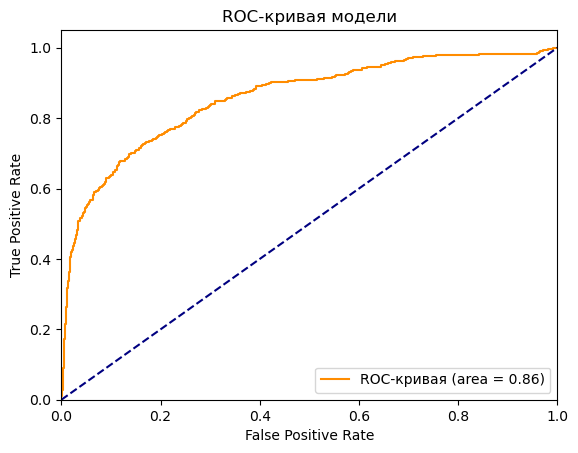

In [35]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr, color='darkorange',
         label='ROC-кривая (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели')
plt.legend(loc="lower right")

plt.show();

Площадь AUC **0,86**, похоже неплохой результат.

In [36]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
f1_score(dummy_model.predict(features_test), target_test)

0.32845800250731305

In [37]:
recall_score(target_test, forest_pred)

0.6564885496183206

**Итоговый вывод:**

В проекте мы изучили данные, разделили файлы на выборки, исследовали разлчные модели, предприняи меры к адаптации моделей к несбалансированности классов, проверили качество на тестовой выборке.

В результате проведенных действий мы получили наиболее точную модель случайного леса с количеством деревьев 41 и глубиной дерева 12, которая дает F1-метрику на тестовой выборке около **0,62**. Таким образом, поставленная цель нами была достигнута. 